# ml_lstm: End-to-end CLI workflow (ingestion → paper trading)

This notebook collects the major project CLIs needed to run the full workflow from data ingestion to paper trading.

High-level steps:
1. Run the daily data pipeline (ingestion, cleaning, gap handling, feature engineering).
2. Train the LSTM model.
3. Evaluate the latest best model.
4. Generate per-bar predictions CSV.
5. Run a backtest using that CSV.
6. Plot backtest diagnostics.
7. Run simulated paper trading using the same CSV.

All `!` shell commands assume this notebook is in `notebooks/` and the project root is the parent directory.

In [34]:
# Global knobs for the workflow
FREQUENCY = "60min"  # e.g. '15min', '30min', '60min'
TSTEPS = 5          # must be consistent with your config / trained models

# Paths derived from FREQUENCY that are reused across steps
PREDICTIONS_CSV = f"backtests/nvda_{FREQUENCY}_predictions.csv"
TRADES_CSV      = f"backtests/nvda_{FREQUENCY}_trades.csv"
EQUITY_CSV      = f"backtests/nvda_{FREQUENCY}_equity.csv"
PRICE_CSV       = f"data/processed/nvda_{FREQUENCY}.csv"


In [35]:
import sys
!{sys.executable} -m pip install tqdm


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import sys
from pathlib import Path

# Adjust this if your notebook is not directly in the project root
project_root = Path(r"C:\Users\Anton\SRC\my\ml_lstm")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## 1. Daily data pipeline (ingestion → processed hourly features)

Runs `src.daily_data_agent` which orchestrates ingestion, cleaning, gap handling, curated minute snapshot, and resampling + feature engineering.

In [39]:
!cd .. && python -m src.daily_data_agent
# For a dry run that skips IB/TWS ingestion, use:
# !cd .. && python -m src.daily_data_agent --skip-ingestion


[agent] --- Daily Data Pipeline Agent start ---
[agent] Starting ingestion from 2024-01-01 00:00:00 to 2025-11-19 09:01:47.634222 into C:\Users\Anton\SRC\my\ml_lstm\data\raw\nvda_minute.csv
An error occurred: [WinError 1225] The remote computer refused the network connection
[agent] Cleaning raw minute data...
Cleaning raw minute data at C:\Users\Anton\SRC\my\ml_lstm\data\raw\nvda_minute.csv...
Raw minute data cleaned and saved to C:\Users\Anton\SRC\my\ml_lstm\data\raw\nvda_minute.csv
[agent] Analyzing and filling gaps...
[agent] Running gap analysis: C:\Users\Anton\SRC\my\ml_lstm\venv\Scripts\python.exe C:\Users\Anton\SRC\my\ml_lstm\src\analyze_gaps.py C:\Users\Anton\SRC\my\ml_lstm\data\raw\nvda_minute.csv C:\Users\Anton\SRC\my\ml_lstm\data\processed\missing_trading_days.json
[agent] analyze_gaps.py stdout:
Analyzing potentially missing trading days in C:\Users\Anton\SRC\my\ml_lstm\data\raw\nvda_minute.csv (excluding weekends and typical overnight closures)...

Found 1 potentially mis

API connection failed: ConnectionRefusedError(22, 'The remote computer refused the network connection', None, 1225, None)
Make sure API port on TWS/IBG is open
API connection failed: ConnectionRefusedError(22, 'The remote computer refused the network connection', None, 1225, None)
Make sure API port on TWS/IBG is open


## 2. Train LSTM model

In [45]:
# Train an LSTM model for the chosen FREQUENCY and TSTEPS using src.train.\n
!cd .. && python -m src.train --frequency {FREQUENCY} --tsteps {TSTEPS}


--- Training model for frequency: 60min, TSTEPS: 5 ---
Scaler parameters calculated on training data and saved to C:\Users\Anton\SRC\my\ml_lstm\data\processed\scaler_params_60min.json
Starting model training for 60min with TSTEPS=5...
Epoch 1/20

  1/144 ==================== 2:58 1s/step - loss: 1.9320 - mae: 1.3864
 12/144 ==================== 0s 5ms/step - loss: 0.8525 - mae: 0.6818 
 28/144 ==================== 0s 4ms/step - loss: 0.4902 - mae: 0.4348
 48/144 ==================== 0s 3ms/step - loss: 0.3368 - mae: 0.3293
 57/144 ==================== 0s 6ms/step - loss: 0.2979 - mae: 0.3016
 73/144 ==================== 0s 5ms/step - loss: 0.2491 - mae: 0.2662
 91/144 ==================== 0s 5ms/step - loss: 0.2119 - mae: 0.2380
110/144 ==================== 0s 4ms/step - loss: 0.1845 - mae: 0.2168
135/144 ==================== 0s 4ms/step - loss: 0.1610 - mae: 0.2007
144/144 ==================== 2s 7ms/step - loss: 0.0585 - mae: 0.1390 - val_loss: 0.3416 - val_mae: 0.4914
Epoch 2/20

 

2025-11-19 09:13:44.135611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 09:13:46.724441: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 09:13:48.933966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. Evaluate latest best model

Evaluate the latest best model (based on `best_hyperparameters.json`) using `src.evaluate_model`.

In [46]:
!cd .. && python -m src.evaluate_model


DEBUG: model_path from get_latest_best_model_path: C:\Users\Anton\SRC\my\ml_lstm\models\registry\my_lstm_model_60min_tsteps5_20251119_091359.keras
DEBUG: bias_correction_path from get_latest_best_model_path: C:\Users\Anton\SRC\my\ml_lstm\models\registry\bias_correction_60min_tsteps5_20251119_091359.json
DEBUG: features_to_use_trained from get_latest_best_model_path: None
DEBUG: lstm_units_trained from get_latest_best_model_path: 32
DEBUG: n_lstm_layers_trained from get_latest_best_model_path: 1
DEBUG: n_features_trained: 7
Loaded bias correction: mean_residual = 11.9015
Loading trained (stateful) model from: C:\Users\Anton\SRC\my\ml_lstm\models\registry\my_lstm_model_60min_tsteps5_20251119_091359.keras
Creating non-stateful model with 32 LSTM units for evaluation...
Loading hourly data and scaler parameters...
Evaluating on 2650 data points from the last validation window.
Generating predictions using sequence method...

 1/42 ==================== 7s 194ms/step
24/42 ==================

2025-11-19 09:15:12.140480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 09:15:14.780203: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 09:15:16.979773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 4. Generate per-bar predictions CSV

Use `scripts.generate_predictions_csv` to create a per-bar predictions file for NVDA at the chosen `FREQUENCY`.

Output columns: `Time`, `predicted_price`.

In [47]:
!cd .. && {sys.executable} -m scripts.generate_predictions_csv --frequency {FREQUENCY} --output {PREDICTIONS_CSV}

Generating predictions for 13454 bars from C:\Users\Anton\SRC\my\ml_lstm\data\processed\nvda_60min.csv...
Wrote predictions for 13454 bars to backtests/nvda_60min_predictions.csv



predict: 100%|##########| 13454/13454 [00:00<00:00, 2249199.49bar/s]


## 5. Run backtest using predictions CSV

Run `src.backtest` over processed OHLC data, using the predictions CSV as the prediction source.

- `--prediction-mode csv` tells the backtest to read `predicted_price` from the CSV.
- Exports trades and equity curve CSVs for diagnostics.

In [48]:
!cd .. && python -m src.backtest --frequency {FREQUENCY} --prediction-mode csv --predictions-csv {PREDICTIONS_CSV} --export-trades-csv {TRADES_CSV} --export-equity-csv {EQUITY_CSV}


Running backtest on 13454 bars at 60min...
Backtest complete. Computing metrics...
Backtest summary | freq=60min | bars=13454 | period=2022-12-30 11:00:00 -> 2025-11-18 17:00:00 | equity: 10000.00 -> 9990.08 | trades=430
Metrics | total_ret=-0.10% | CAGR=-0.03% | max_dd=-32.78% | Sharpe= 0.08 | win_rate=34.42% | PF= 1.00
Figure(1200x600)


C:\Users\Anton\SRC\my\ml_lstm\src\backtest.py:251: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = merged["predicted_price"].fillna(method="ffill").fillna(method="bfill").to_numpy()


## 6. Plot backtest diagnostics

Use `scripts.plot_backtest_diagnostics` to visualize equity curve and trade entry density.

In [49]:
!cd .. && python -m scripts.plot_backtest_diagnostics --equity {EQUITY_CSV} --trades {TRADES_CSV} --price-csv {PRICE_CSV}


Saved diagnostics plot to backtests\backtest_diagnostics.png
Figure(1000x800)


Equity CSV: C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_60min_equity.csv exists: True
Trades CSV: C:\Users\Anton\SRC\my\ml_lstm\backtests\nvda_60min_trades.csv exists: True
Price CSV: C:\Users\Anton\SRC\my\ml_lstm\data\processed\nvda_60min.csv exists: True
Saved diagnostics plot to backtests\backtest_diagnostics.png


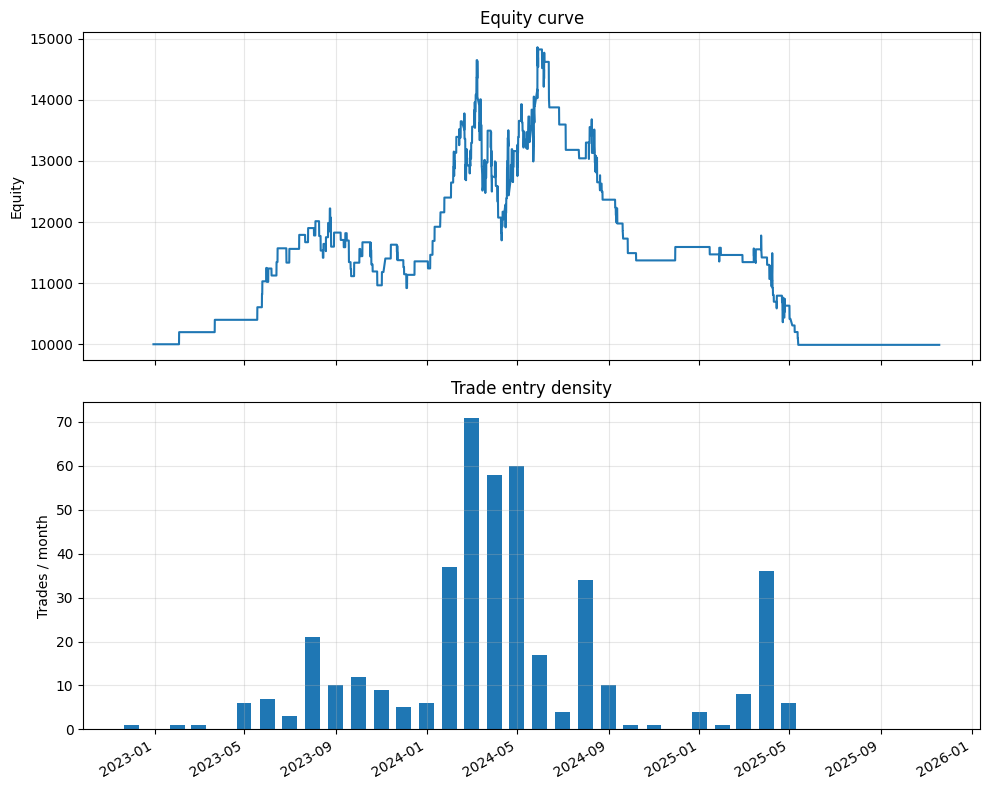

In [54]:
%matplotlib inline
from pathlib import Path
from scripts.plot_backtest_diagnostics import plot_equity_and_trade_density

# Use absolute paths so this cell works regardless of notebook CWD.
project_root = Path("C:/Users/Anton/SRC/my/ml_lstm")
equity_path = project_root / EQUITY_CSV
trades_path = project_root / TRADES_CSV
price_path = project_root / PRICE_CSV

print("Equity CSV:", equity_path, "exists:", equity_path.exists())
print("Trades CSV:", trades_path, "exists:", trades_path.exists())
print("Price CSV:", price_path, "exists:", price_path.exists())

plot_equity_and_trade_density(
                              equity_path=str(equity_path),
                              trades_path=str(trades_path),
                              price_csv_path=str(price_path),
                             )


## 7. Paper trading over historical data

Use `src.paper_trade` to run a simulated paper-trading session over historical NVDA data, reusing the predictions CSV.

In [55]:
!cd .. && python -m src.paper_trade --frequency {FREQUENCY} --predictions-csv {PREDICTIONS_CSV}


[paper] Session summary
Frequency:      60min
Start date:     2022-12-30 11:00:00
End date:       2025-11-18 17:00:00
Initial equity: 10000.00
Final equity:   10051.80
Trades:         458


C:\Users\Anton\SRC\my\ml_lstm\src\backtest.py:251: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = merged["predicted_price"].fillna(method="ffill").fillna(method="bfill").to_numpy()


## 8. (Optional) Hyperparameter tuning and experiment grid

Not required for the minimal ingestion → paper-trading loop, but useful for experimentation.

In [ ]:
# Optional: run hyperparameter tuning (can be long-running)
# !cd .. && python -m src.tune_hyperparameters

# Optional: run a grid of experiments (very long-running)
# !cd .. && python -m src.experiment_runner
